In [1]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/likelion/project2/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/likelion/project2


SFT: 10580개, RM: 26408개, PPO: 25443개 → 총 62431개 데이터


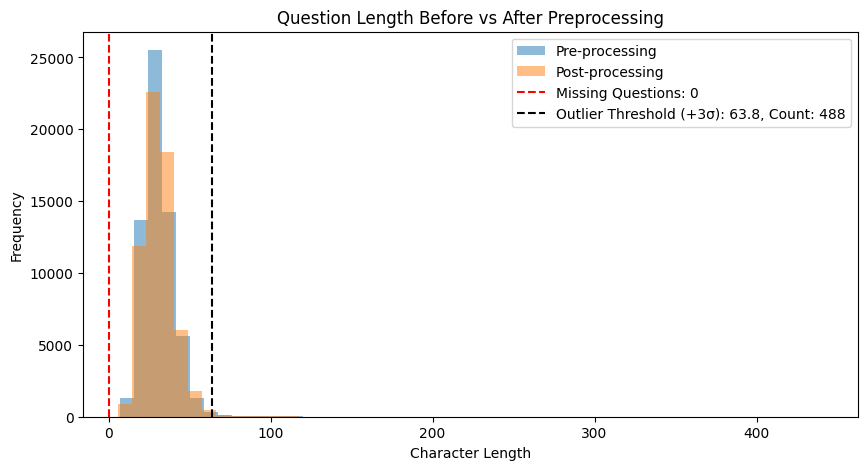

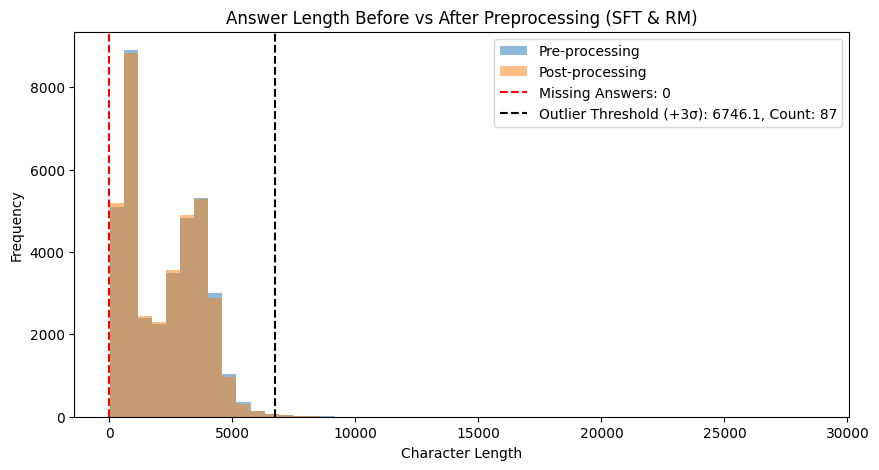

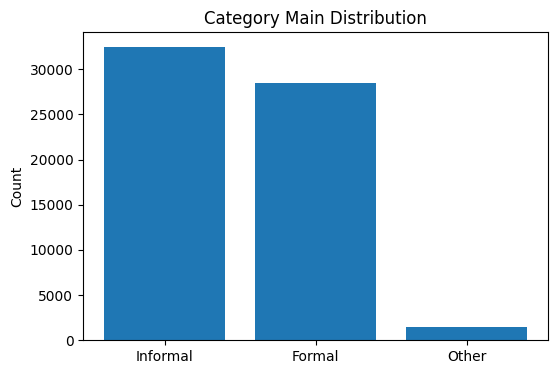

In [2]:
# ============================================================
# 전체 코드: 샘플링 + 전처리 + 전처리 전후 시각화 + EDA (3σ 초과 개수 표시)
# ============================================================

import json
import random
import re
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. 데이터 샘플 비율 설정
# ============================================================
DATA_SAMPLE_RATIO = 1  # 전체 사용 시 1로 설정

def sample_data(data_list, ratio=0.05, seed=42):
    random.seed(seed)
    n_sample = max(1, int(len(data_list) * ratio))
    return random.sample(data_list, n_sample)

# ============================================================
# 2. JSON 파일 로드 함수
# ============================================================
def load_custom_json(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
        return data["data_info"]

# ============================================================
# 3. 텍스트 정제 함수
# ============================================================
def clean_text(text):
    if not text:
        return ""
    text = re.sub(r'\s+', ' ', text)       # 연속된 공백/줄바꿈 제거
    text = re.sub(r'<[^>]+>', '', text)    # HTML 태그 제거
    text = text.replace("“","\"").replace("”","\"").replace("’","'")
    return text.strip()

# ============================================================
# 4. 데이터 전처리 함수
# ============================================================
def preprocess_data(data_list, dataset_type):
    processed = []
    for item in data_list:
        pre_question_len = len(item.get("question", "")) if item.get("question") else 0
        pre_answer_len = 0

        base = {
            "id": item.get("data_id"),
            "dataset_type": dataset_type,
            "question": clean_text(item.get("question", "")),
            "category_main": item.get("data_category", {}).get("main", ""),
            "category_middle": item.get("data_category", {}).get("middle", ""),
            "category_sub": item.get("data_category", {}).get("sub", ""),
            "question_type": item.get("question_type", "")
        }

        # ===== SFT 데이터 처리 =====
        if dataset_type == "SFT":
            answers = []
            ans = item.get("answer", {})
            if isinstance(ans, dict) and "contents" in ans:
                answers.append(clean_text(ans["contents"]))
                pre_answer_len = len(ans["contents"])
            base["answers"] = answers

        # ===== RM 데이터 처리 =====
        elif dataset_type == "RM":
            answers = []
            for key, val in item.items():
                if key.startswith("answer") and isinstance(val, dict):
                    content = val.get("contents")
                    if content:
                        answers.append(clean_text(content))
                        pre_answer_len += len(content)
            base["answers"] = answers

        # ===== PPO 데이터 처리 =====
        elif dataset_type == "PPO":
            base["answers"] = []

        # 전처리 전후 길이 저장
        base["pre_question_len"] = pre_question_len
        base["post_question_len"] = len(base["question"])
        base["pre_answer_len"] = pre_answer_len
        base["post_answer_len"] = sum([len(a) for a in base["answers"]]) if base["answers"] else 0

        processed.append(base)

    return processed

# ============================================================
# 5. 데이터 로드, 샘플링, 전처리
# ============================================================
sft_raw = load_custom_json("./data/train/RLHF_train/SFT.json")
rm_raw = load_custom_json("./data/train/RLHF_train/RM.json")
ppo_raw = load_custom_json("./data/train/RLHF_train/PPO.json")

sft_data = preprocess_data(sample_data(sft_raw, DATA_SAMPLE_RATIO), "SFT")
rm_data = preprocess_data(sample_data(rm_raw, DATA_SAMPLE_RATIO), "RM")
ppo_data = preprocess_data(sample_data(ppo_raw, DATA_SAMPLE_RATIO), "PPO")

# ============================================================
# 6. 통합 데이터 구성
# ============================================================
all_data = sft_data + rm_data + ppo_data
print(f"SFT: {len(sft_data)}개, RM: {len(rm_data)}개, PPO: {len(ppo_data)}개 → 총 {len(all_data)}개 데이터")

# ============================================================
# 7. EDA 준비: Pandas DataFrame 변환
# ============================================================
df = pd.DataFrame(all_data)

# ============================================================
# 8. 전처리 전후 질문 길이 비교 시각화 (결측치/이상치 표시, 3σ 초과 개수)
# ============================================================
plt.figure(figsize=(10,5))
plt.hist(df["pre_question_len"], bins=50, alpha=0.5, label="Pre-processing")
plt.hist(df["post_question_len"], bins=50, alpha=0.5, label="Post-processing")

# 결측치 표시
missing_q = df[df["post_question_len"]==0].shape[0]
plt.axvline(x=0, color='r', linestyle='--', label=f'Missing Questions: {missing_q}')

# 이상치 표시 (3표준편차)
q_mean = df["post_question_len"].mean()
q_std = df["post_question_len"].std()
upper_limit = q_mean + 3*q_std
outlier_count_q = df[df["post_question_len"] > upper_limit].shape[0]
plt.axvline(x=upper_limit, color='k', linestyle='--', label=f'Outlier Threshold (+3σ): {upper_limit:.1f}, Count: {outlier_count_q}')

plt.title("Question Length Before vs After Preprocessing")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# ============================================================
# 9. 전처리 전후 답변 길이 비교 시각화 (SFT & RM, 결측치/이상치 표시)
# ============================================================
plt.figure(figsize=(10,5))
subset = df[df["dataset_type"]!="PPO"]

plt.hist(subset["pre_answer_len"], bins=50, alpha=0.5, label="Pre-processing")
plt.hist(subset["post_answer_len"], bins=50, alpha=0.5, label="Post-processing")

# 결측치
missing_a = subset[subset["post_answer_len"]==0].shape[0]
plt.axvline(x=0, color='r', linestyle='--', label=f'Missing Answers: {missing_a}')

# 이상치 (3표준편차)
a_mean = subset["post_answer_len"].mean()
a_std = subset["post_answer_len"].std()
upper_limit_a = a_mean + 3*a_std
outlier_count_a = subset[subset["post_answer_len"] > upper_limit_a].shape[0]
plt.axvline(x=upper_limit_a, color='k', linestyle='--', label=f'Outlier Threshold (+3σ): {upper_limit_a:.1f}, Count: {outlier_count_a}')

plt.title("Answer Length Before vs After Preprocessing (SFT & RM)")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# ============================================================
# 10. 카테고리별 데이터 비율 시각화 (영문 라벨)
# ============================================================
category_map = {
    "문어체": "Formal",
    "구어체": "Informal",
    "혼합": "Mixed"
}

df["category_main_en"] = df["category_main"].map(lambda x: category_map.get(x, "Other"))
category_counts = Counter(df["category_main_en"])

plt.figure(figsize=(6,4))
plt.bar(category_counts.keys(), category_counts.values())
plt.title("Category Main Distribution")
plt.ylabel("Count")
plt.show()


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
JSON files in ZIP: ['SL01-00-00.json', 'SL01-00-01.json', 'SL01-01-00.json', 'SL01-01-01.json', 'SL01-02-00.json', 'SL01-02-01.json', 'SL01-03-00.json', 'SL01-03-01.json', 'SL01-04-00.json', 'SL01-04-01.json', 'SL01-05-00.json', 'SL01-05-01.json', 'SL01-06-00.json', 'SL01-06-01.json', 'SL01-07-00.json', 'SL01-07-01.json', 'SL02-00-00.json', 'SL02-00-01.json', 'SL02-00-02.json', 'SL02-01-00.json', 'SL02-01-01.json', 'SL02-01-02.json', 'SL02-02-00.json', 'SL02-02-01.json', 'SL02-02-02.json', 'SL02-03-00.json', 'SL02-03-01.json', 'SL02-03-02.json', 'SL02-04-00.json', 'SL02-04-01.json', 'SL02-04-02.json', 'SL02-05-00.json', 'SL02-05-01.json', 'SL02-06-00.json', 'SL02-06-01.json', 'SL02-07-00.json', 'SL02-07-01.json', 'SL03-00-00.json', 'SL04-00-00.json', 'SL04-01-00.json', 'SL04-02-00.json', 'SL04-03-00.

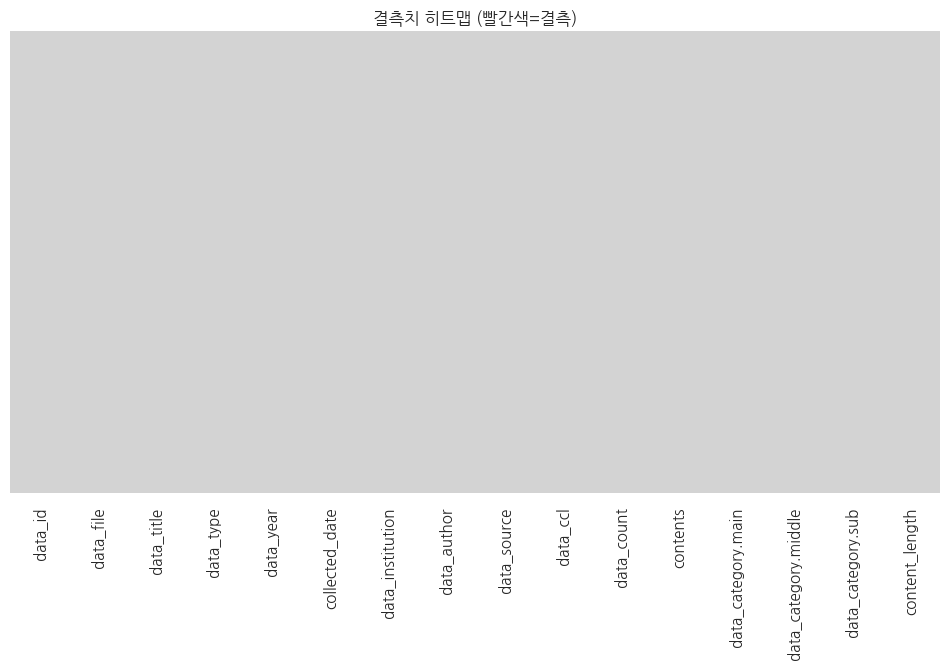

이상치 개수: 340602
이상치 최소값: 3001
이상치 최대값: 994650


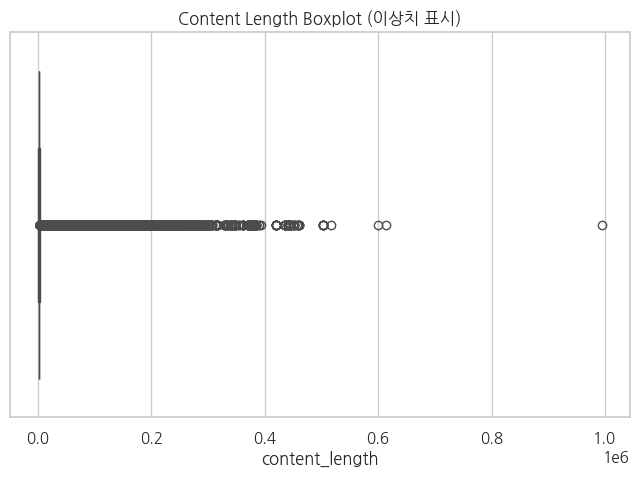

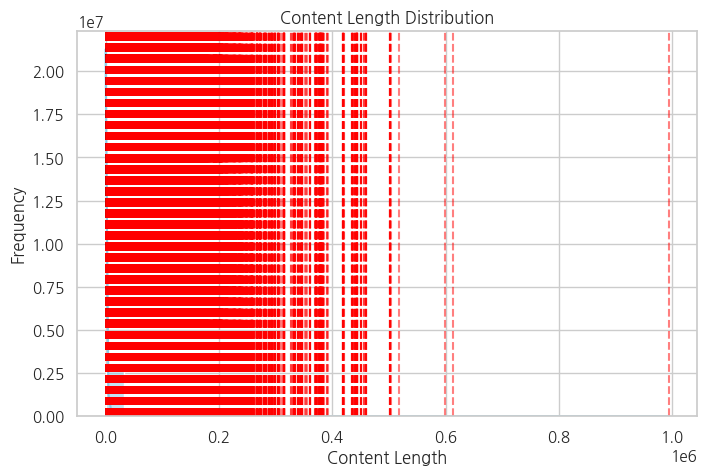

/tmp/ipython-input-148530927.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='data_year', palette='viridis')


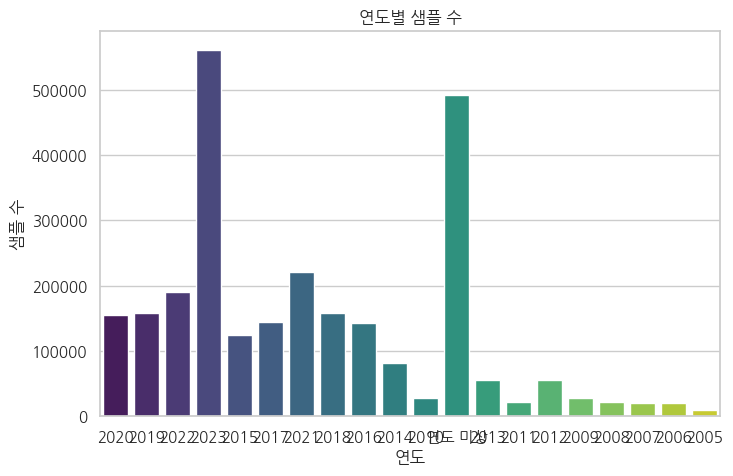

/tmp/ipython-input-148530927.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='data_category.main', palette='pastel')


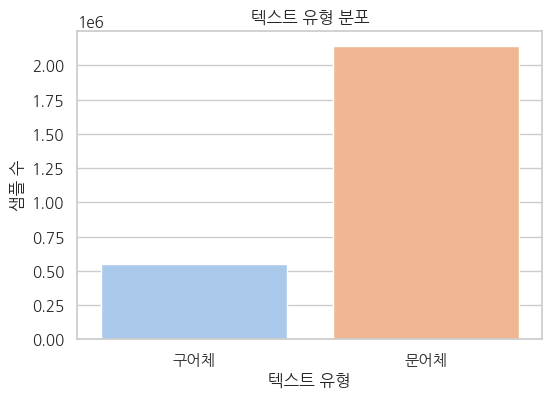

/tmp/ipython-input-148530927.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='data_category.middle', order=df['data_category.middle'].value_counts().index, palette='Set2')


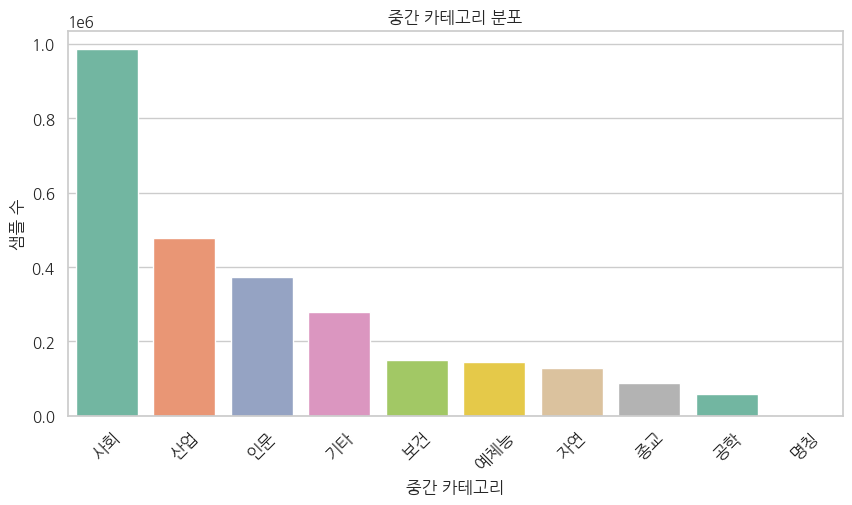

                                data_id  \
0  7933b054-800c-42cd-a1f0-105fd4a62cd5   
1  7adbc3f1-9512-4904-be2b-daf62da1e95c   
2  1569ab2a-20f9-4043-9848-6ae4577de1b5   
3  dbaa6360-327a-4c3e-a673-14b62ddd4177   
4  4682e914-39f3-4af6-913d-4952bbc78989   

                                           data_file  \
0  source08/230901/002/b106be259da5a8a070c06abda2...   
1  source08/230901/006/05e072bcd5d1a9482d8b69c42f...   
2  source08/230901/016/21ac26260b4c9498c336567a05...   
3  source08/230901/019/ab16ea1c392e35ce6c3a4cfa05...   
4  source08/230901/009/1905da8dd8363f87f1088c85ef...   

                                          data_title data_type data_year  \
0                              중세시대 공성전을 리얼하게 구현한 게임        음성      2020   
1        포토샵 강좌 실전 1 👍 포토샵마스크 를 이용해 광고에서 보던 동물사진 만들기        음성      2019   
2  한국에 환상을 갖는 모든 외국인들에게..🥺 *한국에도 인종차별이 존재하나요?* | ...        음성      2022   
3  💥💥【속보입니다!일본을 탈출하라!남태평양 통가 추가강진발생!통가해저화산 2차대폭발위...        음성      2022   
4                       

In [8]:
# --------------------------
# 0. Colab 한글 폰트 설치 및 설정
# --------------------------
!apt-get update -qq
!apt-get install -qq fonts-nanum

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import zipfile
import json
import pandas as pd
import numpy as np
from io import TextIOWrapper

# --------------------------
# 샘플 비율 변수 (0.01 = 1%, 0.5 = 50% 등)
# --------------------------
sample_ratio = 1  # 1%만 사용


# Matplotlib 캐시 초기화
!rm -rf /root/.cache/matplotlib

# NanumGothic 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['axes.unicode_minus'] = False
sns.set(font=fontprop.get_name(), style="whitegrid")

# --------------------------
# 1. Load all JSON files from ZIP and combine
# --------------------------
zip_path = './data/train/korean_train.zip'

all_records = []
with zipfile.ZipFile(zip_path, 'r') as z:
    json_files = [f for f in z.namelist() if f.endswith('.json')]
    print("JSON files in ZIP:", json_files)

    for jf in json_files:
        with z.open(jf) as f:
            data_json = json.load(TextIOWrapper(f, 'utf-8'))
            all_records.extend(data_json['data_info'])  # 모든 레코드 합치기

# --------------------------
# 2. Convert JSON to DataFrame
# --------------------------
df = pd.json_normalize(all_records)

# --------------------------
# 샘플 비율 변수 (0.01 = 1%, 0.5 = 50% 등)
# --------------------------
if 0 < sample_ratio < 1:
    df = df.sample(frac=sample_ratio, random_state=42).reset_index(drop=True)
    print(f"전체 데이터의 {sample_ratio*100:.2f}%를 랜덤 샘플링하여 사용합니다. 샘플 수: {len(df)}")
else:
    print(f"전체 데이터를 사용합니다. 총 샘플 수: {len(df)}")


# --------------------------
# 3. Preprocessing
# --------------------------
df['data_category.main'] = df['data_category.main'].fillna('Unknown')
df['data_category.middle'] = df['data_category.middle'].fillna('Unknown')
df['content_length'] = df['contents'].apply(len)

# --------------------------
# 3-1. 결측치 확인 및 시각화
# --------------------------
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
print("컬럼별 결측치 개수:")
print(missing_counts)

plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cmap=['#D3D3D3','#FF6347'], cbar=False, yticklabels=False)
plt.title('결측치 히트맵 (빨간색=결측)', fontproperties=fontprop)
plt.show()

# --------------------------
# 3-2. 이상치 확인 (content_length 기준)
# --------------------------
Q1 = df['content_length'].quantile(0.25)
Q3 = df['content_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers = df[(df['content_length'] < lower_bound) | (df['content_length'] > upper_bound)]
print(f"이상치 개수: {outliers.shape[0]}")
if not outliers.empty:
    print(f"이상치 최소값: {outliers['content_length'].min()}")
    print(f"이상치 최대값: {outliers['content_length'].max()}")

plt.figure(figsize=(8,5))
sns.boxplot(x=df['content_length'])
plt.title('Content Length Boxplot (이상치 표시)', fontproperties=fontprop)
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df['content_length'], bins=30, kde=True, color='skyblue')
plt.title('Content Length Distribution', fontproperties=fontprop)
plt.xlabel('Content Length', fontproperties=fontprop)
plt.ylabel('Frequency', fontproperties=fontprop)

for outlier_val in outliers['content_length']:
    plt.axvline(outlier_val, color='red', linestyle='--', alpha=0.5)
plt.show()

# --------------------------
# 4. 기존 시각화 유지
# --------------------------
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='data_year', palette='viridis')
plt.title('연도별 샘플 수', fontproperties=fontprop)
plt.xlabel('연도', fontproperties=fontprop)
plt.ylabel('샘플 수', fontproperties=fontprop)
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='data_category.main', palette='pastel')
plt.title('텍스트 유형 분포', fontproperties=fontprop)
plt.xlabel('텍스트 유형', fontproperties=fontprop)
plt.ylabel('샘플 수', fontproperties=fontprop)
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='data_category.middle', order=df['data_category.middle'].value_counts().index, palette='Set2')
plt.title('중간 카테고리 분포', fontproperties=fontprop)
plt.xlabel('중간 카테고리', fontproperties=fontprop)
plt.ylabel('샘플 수', fontproperties=fontprop)
plt.xticks(rotation=45, fontproperties=fontprop)
plt.show()

# --------------------------
# 5. DataFrame 확인
# --------------------------
print(df.head())
